In [1]:
import pysam
import numpy as np
import cPickle as pickle

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

In [4]:
from operator import itemgetter
import pandas as pd

In [5]:
from pyUMI.umiDistAnalyzer import isolated_umis

In [6]:
from pyUMI.umiViews import tag_based_generator, field_based_generator

In [7]:
#AAAGTT  ATATAG  ATCAAA  CCCTGG  CCGGAC  GACCGC  GGCGTC  GTTCGA  TAAAGT  TCTGCA  TTAATC
sample = 'ATATAG'
in_file = '/data/UMI/data/MUS/sample_' + sample + '.bam'

In [224]:
out_file = '/data/UMI/data/MUS/sample_' + sample + '_colored.bam'

In [8]:
st = pysam.AlignmentFile(in_file,"rb")

In [9]:
st.reset()
reads = st.fetch(until_eof=True)

In [10]:
umiques = [r.get_tag('XM') for r in reads if r.has_tag('NH') if r.get_tag('NH')==1]

In [14]:
#sorted(Counter(umiques).items(), key = itemgetter(1), reverse=True)
#'CTGGCGCTCT'

### Collect all unique mapping for trinity 

In [109]:
st.reset()
reads = st.fetch(until_eof=True)

In [110]:
out_file = '/data/TrinityData/sample_' + sample + '.bam'

In [111]:
filtered_reads = pysam.AlignmentFile(out_file, 'wb', template=st)

for r in reads:
    if r.has_tag('NH') and r.get_tag('NH')==1:
        filtered_reads.write(r)
    
filtered_reads.close()
pysam.index(out_file)

''

----------------------------------------------------------------------------

###  Color mappings for IGV

In [53]:
yc_reads = pysam.AlignmentFile(out_file, 'wb', template=st)

red = '255,0,0' # gene tagged uniques from  CTGGCGCTCT
green = '0,255,0' # non-gene tagged uniques from CTGGCGCTCT
blue = '0,0,255' # not used
violet = '255,255,0' # multi maps from CTGGCGCTCT
yellow = '0,255,255' # repeat tagged uniques from CTGGCGCTCT

c1 = '0,0,0' # all other uniques
c2 = '255,255,255' # all other multi maps

for r in reads:
    if r.has_tag('RG'):
        r.set_tag('RG', None)
    if r.get_tag('XM') == 'CTGGCGCTCT':
        if r.has_tag('NH'):
            nh = r.get_tag('NH')
            if nh > 1:
                r.tags += [('YC', violet)]
            else:
                if r.has_tag('GE'):
                    ge = r.get_tag('GE')
                    if 'ENSMUS' in ge:
                        r.tags += [('YC', red)]
                    else:
                        r.tags += [('YC', yellow)]
                else:
                    r.tags += [('YC', green)]
    else:
        if r.has_tag('NH'):
            nh = r.get_tag('NH')
            if nh == 1:
                r.tags += [('YC', c1)]
            else:
                r.tags += [('YC', c2)]
    yc_reads.write(r)
    
yc_reads.close()
pysam.index(out_file)

''

In [225]:
st2 = pysam.AlignmentFile(out_file)
st2.reset()
reads = st2.fetch(until_eof=True)
loci = []
for r in reads:
    if not r.is_unmapped and r.get_tag('XM') == 'CTGGCGCTCT':
        gene = None
        if r.has_tag('GE'):
            gene = r.get_tag('GE')
        loci.append((r.get_tag('NH'), gene, r.reference_name, r.reference_start, r.get_tag('YC')))

In [227]:
loci2 = [item for item in loci if item[1]]
loci2

[(1, 'L1_Mm_dup4278', 'chr13', 44869571, '0,255,255'),
 (1, 'L1_Mm_dup4278', 'chr13', 44869571, '0,255,255'),
 (1, 'L1_Mm_dup4278', 'chr13', 44869571, '0,255,255'),
 (1, 'L1_Mm_dup4278', 'chr13', 44869571, '0,255,255'),
 (1, 'L1_Mm_dup4278', 'chr13', 44869571, '0,255,255'),
 (3, 'LTRIS4B_dup64', 'chr16', 35981592, '255,255,0'),
 (3, 'LTRIS4B_dup64', 'chr16', 35981592, '255,255,0'),
 (3, 'LTRIS4B_dup64', 'chr16', 35981592, '255,255,0'),
 (3, 'LTRIS4B_dup64', 'chr16', 35981592, '255,255,0'),
 (2, 'LTRIS4B_dup64', 'chr16', 35981592, '255,255,0'),
 (3, 'LTRIS4B_dup64', 'chr16', 35981592, '255,255,0'),
 (3, 'LTRIS4B_dup64', 'chr16', 35981592, '255,255,0'),
 (3, 'LTRIS4B_dup64', 'chr16', 35981592, '255,255,0'),
 (3, 'LTRIS4B_dup64', 'chr16', 35981592, '255,255,0'),
 (2, 'Lx_dup21923', 'chr16', 35981620, '255,255,0'),
 (2, 'ENSMUSG00000098973', 'chr9', 110281251, '255,255,0'),
 (1, 'ENSMUSG00000098973', 'chr9', 110281281, '255,0,0'),
 (1, 'ENSMUSG00000098973', 'chr9', 110281281, '255,0,0'),
 

In [ ]:
'''
HISEQ:280:C9J9KANXX:2:1313:14293:94756
HISEQ:280:C9J9KANXX:1:1105:17403:27083
HISEQ:280:C9J9KANXX:1:1104:8662:76337
'''

### Finding PCR duplicates  

In [113]:
index = {}
st.reset()
reads = st.fetch(until_eof=True)
for r in reads:
    if r.has_tag('NH') and r.get_tag('NH')>1:
        qn = r.query_name
        xm = r.get_tag('XM')
        ref = r.reference_name
        start = r.reference_start
        sq = r.query_sequence
        k = (xm, sq, ref, start)
        if k in index:
            index[k].append(qn)
        else:
            index.update({k:[qn]})
        
#HISEQ:280:C9J9KANXX:1:1310:5199:81629

In [114]:
index2 = {}
for k, value in index.items():
    index2.update({k:'-'.join(sorted(value))})

In [97]:
df3 = pd.DataFrame(sorted(index2.items()), columns=['C', 'N'])

In [98]:
df3

,C,N
0,"(AAAAAAAAGT, chr11, 58508744)",HISEQ:280:C9J9KANXX:1:1109:16126:36147-HISEQ:2...
1,"(AAAAAAAAGT, chr14, 46084892)",HISEQ:280:C9J9KANXX:1:1314:2014:57709
2,"(AAAAAAAAGT, chr16, 55971387)",HISEQ:280:C9J9KANXX:1:2107:8457:43965-HISEQ:28...
3,"(AAAAAAAAGT, chr3, 5751214)",HISEQ:280:C9J9KANXX:1:1314:2014:57709
4,"(AAAAAAAAGT, chr3, 10232394)",HISEQ:280:C9J9KANXX:1:1314:2014:57709
5,"(AAAAAAAAGT, chr9, 116040543)",HISEQ:280:C9J9KANXX:1:1109:16126:36147-HISEQ:2...
6,"(AAAAAAAATA, chr1, 15760197)",HISEQ:280:C9J9KANXX:1:2112:9196:8163-HISEQ:280...
7,"(AAAAAAAATA, chr11, 6419481)",HISEQ:280:C9J9KANXX:1:2112:9196:8163-HISEQ:280...
8,"(AAAAAAAATA, chr14, 29218004)",HISEQ:280:C9J9KANXX:1:2112:9196:8163-HISEQ:280...
9,"(AAAAAAAATA, chr19, 16164390)",HISEQ:280:C9J9KANXX:1:2112:9196:8163-HISEQ:280...


In [99]:
%%time
df4 = df3.groupby('N')['C']
#s1 = pd.merge(df, df2, how='inner', on=['N'])

CPU times: user 27 ms, sys: 0 ns, total: 27 ms
Wall time: 30.1 ms


In [100]:
df4

In [101]:
%%time
df5 = pd.DataFrame({'count' : df4.size()}).reset_index()

CPU times: user 9.24 s, sys: 50.6 ms, total: 9.29 s
Wall time: 9.32 s


In [108]:
df5['count'][0]

6

In [106]:
names = df5['N'][0].split('-')

In [107]:
names

['HISEQ:280:C9J9KANXX:1:1101:10004:57158',
 'HISEQ:280:C9J9KANXX:1:1104:2105:10439',
 'HISEQ:280:C9J9KANXX:1:1115:8107:95861',
 'HISEQ:280:C9J9KANXX:1:1207:4216:46538',
 'HISEQ:280:C9J9KANXX:1:1214:4264:28474',
 'HISEQ:280:C9J9KANXX:1:1301:9488:59902',
 'HISEQ:280:C9J9KANXX:1:1305:3088:55926',
 'HISEQ:280:C9J9KANXX:1:2103:17626:42043',
 'HISEQ:280:C9J9KANXX:1:2211:2963:8158',
 'HISEQ:280:C9J9KANXX:1:2308:1865:70760',
 'HISEQ:280:C9J9KANXX:1:2314:14511:100017',
 'HISEQ:280:C9J9KANXX:2:1111:10943:62544',
 'HISEQ:280:C9J9KANXX:2:1111:13113:91414',
 'HISEQ:280:C9J9KANXX:2:1116:12303:14088',
 'HISEQ:280:C9J9KANXX:2:1212:9272:28674',
 'HISEQ:280:C9J9KANXX:2:1306:10878:6620',
 'HISEQ:280:C9J9KANXX:2:2115:19061:49476',
 'HISEQ:280:C9J9KANXX:2:2116:19213:68818',
 'HISEQ:280:C9J9KANXX:2:2211:11295:99716',
 'HISEQ:280:C9J9KANXX:2:2302:11485:68930',
 'HISEQ:280:C9J9KANXX:2:2304:3356:56566',
 'HISEQ:280:C9J9KANXX:2:2309:3820:36980']

In [111]:
st.reset()
l = []
reads = st.fetch(until_eof=True)
for r in reads:
    if r.query_name in names:
        l.append(r.query_sequence)

In [112]:
Counter(l)

Counter({'GTTTGTCTCAATAGGCCATTTAAGTATAATAGTAAAAGACTGGTTAATGA': 2,
         'GTTTGTCTCAATTGGCCATTTAAGATTAATAGTAAAAGACTGGTTAATGA': 2,
         'GTTTGTCTCAATTGGCCATTTAAGTTTAATAGTAAAAGACTGGTTAATGA': 38,
         'GTTTGTCTCAATTGGCCATTTAAGTTTAATAGTAAACGACTGGTTAATGA': 2,
         'TCATTAACCAGTCGTTTACTATTAAACTTAAATGGCCAATTGAGACAAAC': 4,
         'TCATTAACCAGTCTTTTACTATTAAACTTAAATGGCCAATTGAGACAAAC': 76,
         'TCATTAACCAGTCTTTTACTATTAATCTTAAATGGCCAATTGAGACAAAC': 4,
         'TCATTAACCAGTCTTTTACTATTATACTTAAATGGCCTATTGAGACAAAC': 4})

In [28]:
from collections import Counter
Counter(df5['count'])
len(df5['count'])

1138946

-------------------------------

### Finding splicing outliers 

In [30]:
cigars = []
st.reset()
reads = st.fetch(until_eof= True)
for r in reads:
    if not r.is_unmapped:
        cigars.append(r.cigarstring)

In [49]:
spliced = [item for item in cigars if 'N' in item]

In [51]:
sn = [item.split('N')[0].split('M')[1] for item in spliced]

In [94]:
round(float(len(sn)) / len(cigars) * 100, 2)

8.79

In [54]:
sn2 = [int(item) for item in sn if not any(c.isalpha() for c in item)]

In [60]:
import matplotlib.pyplot as plt

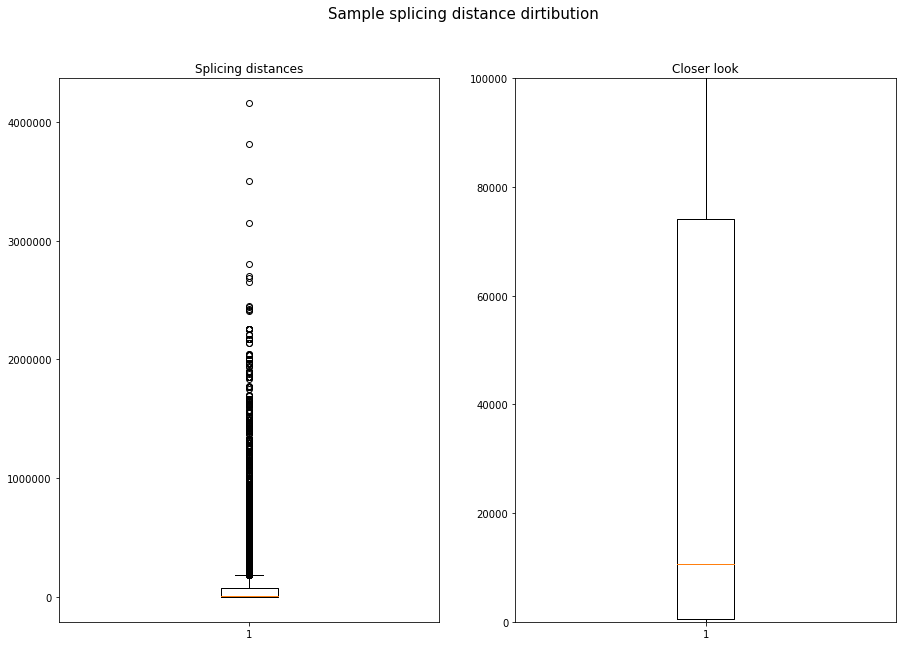

In [89]:
fig = plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
plt.boxplot(sn2)
plt.title('Splicing distances')

plt.subplot(1, 2, 2)
plt.boxplot(sn2)
plt.title('Closer look')
plt.ylim(0,100000)

plt.suptitle('Sample splicing distance dirtibution', fontsize=15)
plt.savefig('spd.png')

1 - Define a GenomicArrayOfSets and fill it with all the features we would like to get counts for.

In [5]:
'''
gtf_file = HTSeq.GFF_Reader( "/data/UMI/data/MUS/Mus_musculus.GRCm38.88.chr.gtf" )
exons = HTSeq.GenomicArrayOfSets( "auto", stranded=True )

for feature in gtf_file:
    if feature.type == "exon":
       exons[ feature.iv ] += feature.attr["gene_id"]
'''

-------------------------------------------------

### Exonmeter

In [115]:
from pyUMI.GTF import dataframe

In [120]:
gtf = '/data/UMI/data/MUS/Mus_musculus.GRCm38.75.clean.spike.gtf'

In [121]:
gdf = dataframe(gtf)

In [123]:
gdf

,ccds_id,end,exon_id,exon_number,feature,frame,gene_biotype,gene_id,gene_name,gene_source,protein_id,score,seqname,source,start,strand,tag,transcript_id,transcript_name,transcript_source
0,None,3054733,None,None,gene,None,pseudogene,ENSMUSG00000090025,Gm16088,havana,None,None,chr1,pseudogene,3054233,+,None,None,None,None
1,None,3054733,None,None,transcript,None,pseudogene,ENSMUSG00000090025,Gm16088,havana,None,None,chr1,unprocessed_pseudogene,3054233,+,mRNA_start_NF,ENSMUST00000160944,Gm16088-001,havana
2,None,3054733,ENSMUSE00000848981,1,exon,None,pseudogene,ENSMUSG00000090025,Gm16088,havana,None,None,chr1,unprocessed_pseudogene,3054233,+,mRNA_start_NF,ENSMUST00000160944,Gm16088-001,havana
3,None,3102125,None,None,gene,None,snRNA,ENSMUSG00000064842,Gm26206,ensembl,None,None,chr1,snRNA,3102016,+,None,None,None,None
4,None,3102125,None,None,transcript,None,snRNA,ENSMUSG00000064842,Gm26206,ensembl,None,None,chr1,snRNA,3102016,+,None,ENSMUST00000082908,Gm26206-201,ensembl
5,None,3102125,ENSMUSE00000522066,1,exon,None,snRNA,ENSMUSG00000064842,Gm26206,ensembl,None,None,chr1,snRNA,3102016,+,None,ENSMUST00000082908,Gm26206-201,ensembl
6,None,3671498,None,None,gene,None,protein_coding,ENSMUSG00000051951,Xkr4,ensembl_havana,None,None,chr1,protein_coding,3205901,-,None,None,None,None
7,None,3216344,None,None,transcript,None,protein_coding,ENSMUSG00000051951,Xkr4,ensembl_havana,None,None,chr1,processed_transcript,3205901,-,mRNA_start_NF,ENSMUST00000162897,Xkr4-003,havana
8,None,3216344,ENSMUSE00000858910,1,exon,None,protein_coding,ENSMUSG00000051951,Xkr4,ensembl_havana,None,None,chr1,processed_transcript,3213609,-,mRNA_start_NF,ENSMUST00000162897,Xkr4-003,havana
9,None,3207317,ENSMUSE00000866652,2,exon,None,protein_coding,ENSMUSG00000051951,Xkr4,ensembl_havana,None,None,chr1,processed_transcript,3205901,-,mRNA_start_NF,ENSMUST00000162897,Xkr4-003,havana


In [171]:
x = gdf[(gdf['feature'] == 'exon') & (gdf['seqname'].str.contains("chr"))& (gdf['strand'] == '-')][['seqname', 'start', 'end']]

In [172]:
x = gdf[(gdf['feature'] == 'exon') & (gdf['seqname'].str.contains("chr"))& (gdf['strand'] == '+')][['seqname', 'start', 'end']]

In [178]:
fx = x.sort_values(by=['seqname','start'])
fx = fx.drop_duplicates()
fx = fx.reset_index(drop=True)
rx = y.sort_values(by=['seqname','start'])
rx = rx.drop_duplicates()
rx = rx.reset_index(drop=True)

In [138]:
def overlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))

In [193]:
#rx.iloc[1:]
fx1 = fx[(fx['seqname']=='chr1')]
#fx1['new_col'] = list(zip(fx1.start, fx1.end));

In [221]:
s = pd.to_numeric(fx1.iloc[1:]['start'])
e = pd.to_numeric(fx1.iloc[:-1]['end'])

#test = [int(i) - int(j) for i,j in zip(s,e)]
pos = [item for item in list(s.subtract(e)) if item >= 0]

In [222]:
pos

[]

In [189]:
test

,seqname_x,start_x,end_x,new_col,seqname_y,start_y,end_y
0,chr1,100050642,100050789,"(100050642, 100050789)",NaN,NaN,NaN
1,chr1,100072048,100072251,"(100072048, 100072251)",chr1,100072048,100072251
2,chr1,100076030,100076214,"(100076030, 100076214)",chr1,100076030,100076214
3,chr1,100097734,100097874,"(100097734, 100097874)",chr1,100097734,100097874
4,chr1,100141174,100141438,"(100141174, 100141438)",chr1,100141174,100141438
5,chr1,100160038,100160187,"(100160038, 100160187)",chr1,100160038,100160187
6,chr1,100164068,100164239,"(100164068, 100164239)",chr1,100164068,100164239
7,chr1,100213667,100213773,"(100213667, 100213773)",chr1,100213667,100213773
8,chr1,100255059,100255178,"(100255059, 100255178)",chr1,100255059,100255178
9,chr1,100274361,100274561,"(100274361, 100274561)",chr1,100274361,100274561


In [75]:
from itertools import islice

In [123]:
%%time
#genes = Counter(gdf['gene_id']).keys()
x = gdf[gdf['seqname'] == 'chr1']['gene_id']
genes = Counter(x).keys()
sgdf = gdf[(gdf['seqname'] == 'chr1')&(gdf['feature'] == 'exon')]

CPU times: user 344 ms, sys: 0 ns, total: 344 ms
Wall time: 344 ms


In [125]:
%%time
coo = []
for gene in genes:
    r = []
    se = sgdf[sgdf['gene_id'] == gene][['start', 'end']]
    start = se['start'].min()
    end = se['end'].max()
    coo.append((start, end))

CPU times: user 12.3 s, sys: 918 µs, total: 12.3 s
Wall time: 12.3 s


In [49]:
coo

(86357414, 86357464)

In [102]:
gdf[gdf['seqname'] == 'chr1']

,end,feature,frame,gene_id,score,seqname,source,start,strand,transcript_id
0,3207317,exon,None,uc007aet.1,0.000000,chr1,mm10_knownGene,3205904,-,uc007aet.1
1,3215632,exon,None,uc007aet.1,0.000000,chr1,mm10_knownGene,3213439,-,uc007aet.1
2,3216024,stop_codon,None,uc007aeu.1,0.000000,chr1,mm10_knownGene,3216022,-,uc007aeu.1
3,3216968,CDS,2,uc007aeu.1,0.000000,chr1,mm10_knownGene,3216025,-,uc007aeu.1
4,3216968,exon,None,uc007aeu.1,0.000000,chr1,mm10_knownGene,3214482,-,uc007aeu.1
5,3421901,CDS,1,uc007aeu.1,0.000000,chr1,mm10_knownGene,3421702,-,uc007aeu.1
6,3421901,exon,None,uc007aeu.1,0.000000,chr1,mm10_knownGene,3421702,-,uc007aeu.1
7,3671348,CDS,0,uc007aeu.1,0.000000,chr1,mm10_knownGene,3670552,-,uc007aeu.1
8,3671348,start_codon,None,uc007aeu.1,0.000000,chr1,mm10_knownGene,3671346,-,uc007aeu.1
9,3671498,exon,None,uc007aeu.1,0.000000,chr1,mm10_knownGene,3670552,-,uc007aeu.1


In [ ]:
genes = [row['gene_id'] for row in ]

In [87]:
igdf = islice(gdf.iterrows(), 100)
for index, row in igdf:
    if row['feature'] == 'exon' and row['seqname'] == 'chr1' and row['gene_id'] == gene:
        print row['start'], row['end']

3205904 3207317
3213439 3215632


In [37]:
gdf2 = dataframe('/data/UMI/data/MUS/Mus_musculus.GRCm38.88.chr.gtf')

In [38]:
gdf2

,ccds_id,end,exon_id,exon_number,exon_version,feature,frame,gene_biotype,gene_id,gene_name,...,source,start,strand,tag,transcript_biotype,transcript_id,transcript_name,transcript_source,transcript_support_level,transcript_version
0,None,3074322,None,None,None,gene,None,TEC,ENSMUSG00000102693,4933401J01Rik,...,havana,3073253,+,None,None,None,None,None,None,None
1,None,3074322,None,None,None,transcript,None,TEC,ENSMUSG00000102693,4933401J01Rik,...,havana,3073253,+,basic,TEC,ENSMUST00000193812,4933401J01Rik-001,havana,None,1
2,None,3074322,ENSMUSE00001343744,1,1,exon,None,TEC,ENSMUSG00000102693,4933401J01Rik,...,havana,3073253,+,basic,TEC,ENSMUST00000193812,4933401J01Rik-001,havana,None,1
3,None,3102125,None,None,None,gene,None,snRNA,ENSMUSG00000064842,Gm26206,...,ensembl,3102016,+,None,None,None,None,None,None,None
4,None,3102125,None,None,None,transcript,None,snRNA,ENSMUSG00000064842,Gm26206,...,ensembl,3102016,+,basic,snRNA,ENSMUST00000082908,Gm26206-201,ensembl,None,1
5,None,3102125,ENSMUSE00000522066,1,1,exon,None,snRNA,ENSMUSG00000064842,Gm26206,...,ensembl,3102016,+,basic,snRNA,ENSMUST00000082908,Gm26206-201,ensembl,None,1
6,None,3671498,None,None,None,gene,None,protein_coding,ENSMUSG00000051951,Xkr4,...,ensembl_havana,3205901,-,None,None,None,None,None,None,None
7,None,3216344,None,None,None,transcript,None,protein_coding,ENSMUSG00000051951,Xkr4,...,havana,3205901,-,None,processed_transcript,ENSMUST00000162897,Xkr4-003,havana,1,1
8,None,3216344,ENSMUSE00000858910,1,1,exon,None,protein_coding,ENSMUSG00000051951,Xkr4,...,havana,3213609,-,None,processed_transcript,ENSMUST00000162897,Xkr4-003,havana,1,1
9,None,3207317,ENSMUSE00000866652,2,1,exon,None,protein_coding,ENSMUSG00000051951,Xkr4,...,havana,3205901,-,None,processed_transcript,ENSMUST00000162897,Xkr4-003,havana,1,1


In [46]:
%%time
#genes = Counter(gdf['gene_id']).keys()
#x = gdf2[gdf2['seqname'] == 'chr1']['ENSMUSG00000026234']
#genes = Counter(x).keys()
sgdf = gdf2[(gdf2['feature'] == 'exon')&(gdf2['gene_id'] == 'ENSMUSG00000026234')][['start', 'end', 'exon_number']]

CPU times: user 409 ms, sys: 110 ms, total: 519 ms
Wall time: 520 ms


In [75]:
def overlap(t1, t2):
    i, j = t1
    w, z = t2
    a = set(range(i, j))
    b = set(range(w, z))
    if a.intersection(b):
        return True
    return False

In [76]:
exons = []
for item in rco:
    for index, row in sgdf.iterrows():
        s = int(row['start'])
        e = int(row['end'])
        if overlap(item, (s, e)):
            exons.append(row['exon_number'])

In [84]:
exon_st = int(sgdf[sgdf['exon_number'] == '3']['start'].min())
exon_ed = int(sgdf[sgdf['exon_number'] == '3']['end'].max())

In [85]:
exon_ed - exon_st

6888

In [81]:
sgdf[sgdf['exon_number'] == '3']

,start,end,exon_number
48459,86356957,86357452,3
48489,86356957,86357452,3
48505,86350564,86350696,3
48514,86357312,86357452,3


In [86]:
sgdf

,start,end,exon_number
48454,86359206,86359400,1
48457,86358107,86358223,2
48459,86356957,86357452,3
48461,86356556,86356741,4
48463,86356371,86356457,5
48465,86356052,86356193,6
48467,86355020,86355144,7
48469,86353732,86353855,8
48471,86353126,86353280,9
48473,86352510,86352633,10


In [110]:
umi_q = {}
for r in reads:
    if not r.is_unmapped and r.get_tag('NH') == 1:
        xm = r.get_tag('XM')
        qn = r.query_name
        ge = None
        if r.has_tag('GE'):
            ge = r.get_tag('GE')
        ref = r.reference_name
        start = r.reference_start
        props = (ge, ref, start)
        
        if xm in umi_q:
            umi_q[xm].update({qn:props})
        else:
            umi_q.update({xm:{qn:props}})

In [114]:
pickle.dump(umi_q,open('Umique.pkl','wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [115]:
population = []
for i in umi_q:
    if len(umi_q[i])==681:
        umi1 = umi_q[i].copy()

In [119]:
chrs = [j for i,j,k in umi1.values()]

In [121]:
c7 = []
for item in umi1:
    i,j,k = umi1[item]
    if j == 'chr7':
        c7.append((k))

In [163]:
o = Counter(c7)
med = np.mean(o.keys())

v = sorted(Counter(c7).items())
d1 = [i for i,j in v]
data1 = [int((i-med)/100000) for i in d1]
data2 = [j for i,j in v]

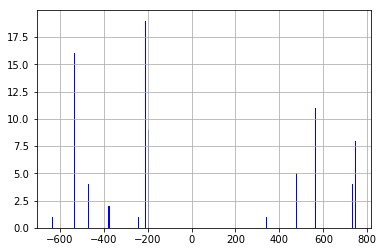

In [164]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.grid()
ax = plt.subplot(111)
#plt.ylim(0, 50000)
#plt.xlim(data1[0],data1[-1])
#plt.xticks(np.arange(data1[0],data1[-1], 50))

ax.bar(data1,data2, width=5, color='b')
plt.show()

In [3]:
import pysam

sample = 'ATATAG'
in_file = '/data/UMI/data/MUS/sample_' + sample + '.bam'
st = pysam.AlignmentFile(in_file,"rb")

st.reset()
reads = st.fetch(until_eof=True)
for r in reads:
    if not r.is_unmapped and r.get_tag('XM') == 'GATGACATGA':
        print r.reference_name, r.reference_start
        print r

chr11 20091755
HISEQ:280:C9J9KANXX:1:2215:15146:97826	0	1	20091755	3	50M	-1	-1	50	GGTCTGAAGTTCAAATCACAGCAACCACATGGTGGCTCACAACCATCTGT	array('B', [27, 18, 18, 14, 22, 34, 34, 29, 37, 15, 15, 31, 38, 38, 37, 38, 29, 15, 28, 34, 37, 33, 37, 38, 21, 28, 32, 25, 37, 29, 15, 15, 15, 15, 14, 15, 14, 22, 36, 30, 38, 38, 14, 23, 32, 37, 2, 2, 2, 2])	[('XC', 'ATATAG'), ('GE', 'B2_Mm1t_dup14786'), ('XF', 'CODING'), ('PG', 'STAR'), ('RG', 'A'), ('NH', 2), ('NM', 1), ('XM', 'GATGACATGA'), ('UQ', 15), ('AS', 47), ('GS', '+')]
chr11 20180683
HISEQ:280:C9J9KANXX:1:2215:15146:97826	256	1	20180683	3	50M	-1	-1	50	GGTCTGAAGTTCAAATCACAGCAACCACATGGTGGCTCACAACCATCTGT	array('B', [27, 18, 18, 14, 22, 34, 34, 29, 37, 15, 15, 31, 38, 38, 37, 38, 29, 15, 28, 34, 37, 33, 37, 38, 21, 28, 32, 25, 37, 29, 15, 15, 15, 15, 14, 15, 14, 22, 36, 30, 38, 38, 14, 23, 32, 37, 2, 2, 2, 2])	[('XC', 'ATATAG'), ('GE', 'B2_Mm1a_dup11405'), ('XF', 'CODING'), ('PG', 'STAR'), ('RG', 'A'), ('NH', 2), ('NM', 1), ('XM', 'GATGACATGA'), (